In [3]:
import os
os.chdir('../py')

import gc

import pandas as pd
import numpy as np
import feather

from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'Ricty Diminised'
sns.set(style="whitegrid", font='Ricty Diminised', palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

import japanize_matplotlib

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

# my modules
import EDA
import utils

from scipy.stats import ks_2samp

In [8]:
import datetime

In [4]:
import super_aggre

In [27]:
train = feather.read_dataframe('../input/feather/train.ftr')
test = feather.read_dataframe('../input/feather/test.ftr')

In [28]:
def datetime_converter(df):
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')    
    df = df.assign(
            # New feature - decimal part of the transaction amount
            TransactionAmt_decimal = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int),

            # Count encoding for card1 feature. 
            # Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
            card1_count_full = df['card1'].map(df['card1'].value_counts(dropna=False)),

            # https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
            Transaction_day_of_week = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7),
            Transaction_hour = np.floor(df['TransactionDT'] / 3600) % 24,

            TransactionDT = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x))),
        )
    df = df.assign(
            # Time of Day
            year = df['TransactionDT'].dt.year,
            month = df['TransactionDT'].dt.month,
            dow = df['TransactionDT'].dt.dayofweek,
            quarter = df['TransactionDT'].dt.quarter,
            hour = df['TransactionDT'].dt.hour,
            day = df['TransactionDT'].dt.day,

            # All NaN
            all_group_nan_sum = df.isnull().sum(axis=1) / df.shape[1],
            all_group_0_count = (df == 0).astype(int).sum(axis=1) / (df.shape[1] - df.isnull().sum(axis=1))
    )
    
    return df

In [29]:
train = datetime_converter(train)
test  = datetime_converter(test)

In [10]:
EDA.max_disp(train.head())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_decimal,card1_count_full,Transaction_day_of_week,Transaction_hour,year,month,dow,quarter,hour,day,all_group_nan_sum,all_group_0_count
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,No

In [12]:
train['year_month'] = train['year'] * 100 + train['month']
train['year_month_date'] = train['year'] * 10000 + train['month'] * 100 + train['day']

In [13]:
EDA.max_disp(train.head())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_decimal,card1_count_full,Transaction_day_of_week,Transaction_hour,year,month,dow,quarter,hour,day,all_group_nan_sum,all_group_0_count,year_month,year_month_date
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,No

In [15]:
train['year_month_date'].map(train['year_month_date'].value_counts())

0         5122
1         5122
2         5122
3         5122
4         5122
5         5122
6         5122
7         5122
8         5122
9         5122
10        5122
11        5122
12        5122
13        5122
14        5122
15        5122
16        5122
17        5122
18        5122
19        5122
20        5122
21        5122
22        5122
23        5122
24        5122
25        5122
26        5122
27        5122
28        5122
29        5122
          ... 
590510    2754
590511    2754
590512    2754
590513    2754
590514    2754
590515    2754
590516    2754
590517    2754
590518    2754
590519    2754
590520    2754
590521    2754
590522    2754
590523    2754
590524    2754
590525    2754
590526    2754
590527    2754
590528    2754
590529    2754
590530    2754
590531    2754
590532    2754
590533    2754
590534    2754
590535    2754
590536    2754
590537    2754
590538    2754
590539    2754
Name: year_month_date, Length: 590540, dtype: int64

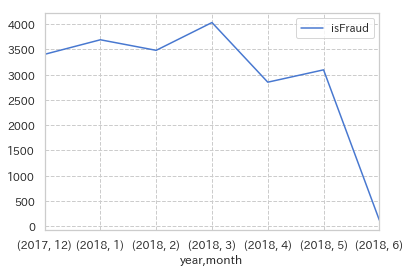

In [31]:
train.groupby(['year', 'month']).agg({'isFraud': 'sum'}).plot()

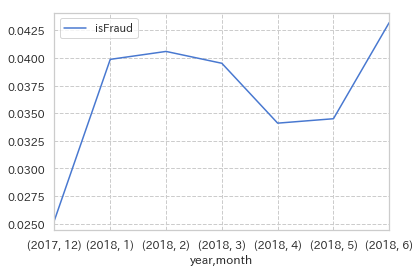

In [32]:
train.groupby(['year', 'month']).agg({'isFraud': 'mean'}).plot()

In [38]:
agg = train.groupby(['year', 'month', 'card1']).agg({'isFraud': 'sum'}).sort_values('isFraud', ascending=False).reset_index()

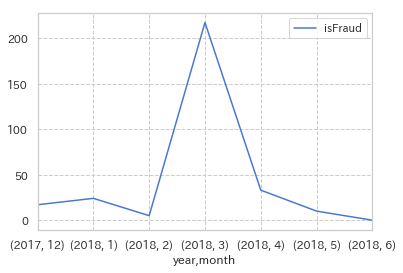

In [42]:
agg[agg['card1'] == 9917].sort_values(['year', 'month']).set_index(['year', 'month']).drop(columns='card1').plot()

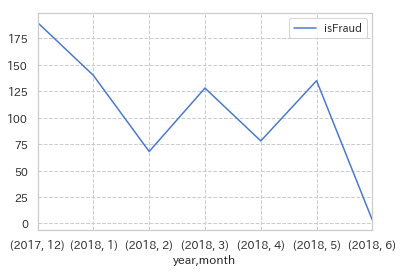

In [43]:
agg[agg['card1'] == 9633].sort_values(['year', 'month']).set_index(['year', 'month']).drop(columns='card1').plot()

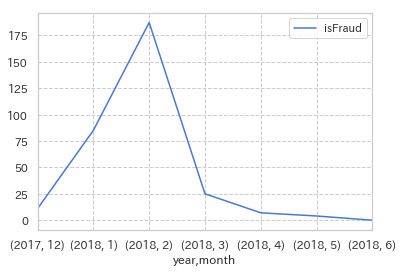

In [44]:
agg[agg['card1'] == 15063].sort_values(['year', 'month']).set_index(['year', 'month']).drop(columns='card1').plot()

In [37]:
agg

isFraud
year month card1         
2018 3     9917     217.0
2017 12    9633     190.0
2018 2     15063    187.0
     1     9633     140.0
     5     9633     135.0
     3     9633     128.0
     5     9500     105.0
2017 12    17188    104.0
2018 3     9500      99.0
     1     15066     97.0
     5     15885     97.0
     4     9026      93.0
     3     15885     92.0
           9026      91.0
     1     9500      87.0
           15063     85.0
     4     9500      82.0
     2     9500      81.0
     5     5812      80.0
     4     9633      78.0
     1     6019      76.0
           15885     74.0
           14276     74.0
2017 12    9500      70.0
           15885     69.0
2018 4     2616      68.0
     2     9633      68.0
     1     9026      67.0
2017 12    7585      65.0
2018 5     2616      62.0
...                   ...
     1     16081      0.0
           16086      0.0
           16017      0.0
           16088      0.0
           16094      0.0
           16095      0.0
           16099      0.0
           16100      0.0
           16101      0.0
           16102      0.0
           16059      0.0
           16056      0.0
           16055      0.0
           16053      0.0
           16024      0.0
           16025      0.0
           16030      0.0
           16033      0.0
           16037      0.0
           16038      0.0
           16040      0.0
           16041      0.0
           16042      0.0
           16043      0.0
           16045      0.0
           16046      0.0
           16048      0.0
           16050      0.0
           16051      0.0
     6     18375      0.0

[41926 rows x 1 columns]

In [46]:
addr1_agg = train.groupby(['year', 'month', 'addr1']).agg({'isFraud': 'sum'}).sort_values('isFraud', ascending=False).reset_index()

In [49]:
top_addr = addr1_agg.head()['addr1'].values

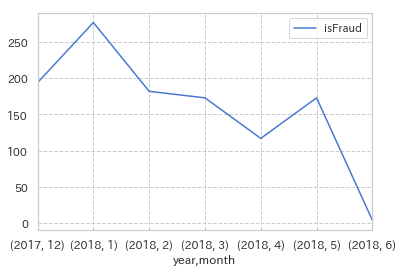

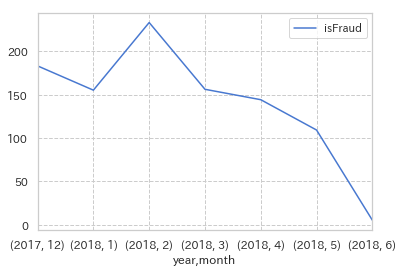

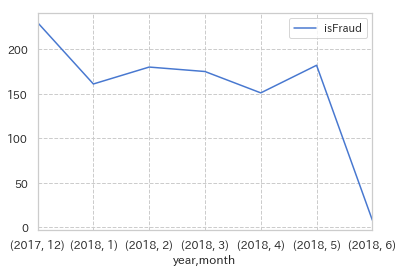

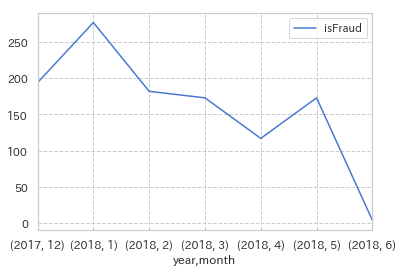

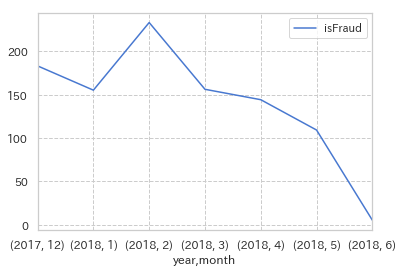

In [51]:
for addr in top_addr:
    addr1_agg[addr1_agg['addr1'] == addr].sort_values(['year', 'month']).set_index(['year', 'month']).drop(columns='addr1').plot()

In [55]:
test['TransactionDT'].dtype

dtype('<M8[ns]')

In [60]:
import re

In [77]:
re.search("\('.*'\)", "dtype('int32')").group()

"('int32')"

In [82]:
dict(train.columns, [str(i) for i in train.dtypes])

TypeError: dict expected at most 1 arguments, got 2